## Compute Laplacian

In [1]:
## IMPORT LIBRARIES 
import os
import sys
import igl
import time
import torch
import numpy as np
import meshplot as mp
from typing import Tuple
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## IMPORT SOURCE
from smpl_torch_batch import SMPLModel

In [2]:
## LOAD ANIMATION DATA (ORIGINAL SCANS OF SINGLE INSTANCE)

training_data = torch.load('../data/50004_dataset.pt')
data_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False)

device = "cpu"
smpl_model = SMPLModel(device=device, model_path='../body_models/smpl/female/model.pkl')

for data in data_loader:
    target_verts = data[1].squeeze()
    V = np.array(target_verts, dtype=float)
    F = np.array(smpl_model.faces, dtype=int)
    break
    

In [3]:
## Get Smoothed Animation

smoothing_steps = 10
verbose = False

v_smooth_arr = [] #v_smoothed = np.empty_like(V) (Somehow meshplot doesnt work with np)
anim_length = V.shape[0]
for i in range(anim_length):
    
    v_smooth_arr.append(V[i]) # v_smoothed[i] = V[i]
    for j in range(smoothing_steps):
        v_smooth_arr[i] = igl.per_vertex_attribute_smoothing(v_smooth_arr[i], F)
             
    if verbose:
        if (i+1) % 10 == 0: print(">> Step ", i+1, "/", anim_length)



In [4]:
# PLOT THE SMOOTHED ANIMATION

v_start = v_smooth_arr[0]
p = mp.plot(v_start, F)

for k in range(2):
    for i in range(anim_length):

        v_new = v_smooth_arr[i]
        p.update_object(vertices=v_new)
        v = v_new
        time.sleep(0.1)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0363706…

KeyboardInterrupt: 

## Experiments

In [5]:
def generate_sine_wave(
    amplitude: float,
    frequency: float,
    phase: float,
    sampling_rate: int,
    duration: float) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """Generates a sine wave

    Args:
        amplitude (float): Amplitude
        frequency (float): Frequnecy [Hz]
        phase (float): Phase [rad]
        sampling_rate (int): Sampling rate[Hz]
        duration (float): Duration [s]

    Returns:
        Tuple[torch.FloatTensor, torch.FloatTensor]: t, y(t)
    """
    total_steps = int(sampling_rate * duration)
    t = torch.linspace(0, duration, total_steps)
    y = amplitude * torch.sin(2 * np.pi * frequency * t + phase)

    return t, y

In [40]:
def plot_fft(signal, fourier, sampling_rate = 1_000):
    absolutes = fourier.abs()
    freq = torch.fft.rfftfreq(len(signal), 1/sampling_rate)
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Frequencies')
    ax.set_ylabel('$|F(s)|$')
    ax.grid()
    ax.scatter(x=freq, y=absolutes, s=8)

    plt.savefig('./plots/fourier_transform_sampling_{}_{}.png'.format(sampling_rate, time.time()))
    
    return absolutes, freq

In [35]:
V_smooth_tensor = torch.from_numpy(np.array(v_smooth_arr))
V_tensor = torch.from_numpy(V)

print(V_smooth_tensor.shape, V_tensor.shape)


torch.Size([268, 6890, 3]) torch.Size([268, 6890, 3])


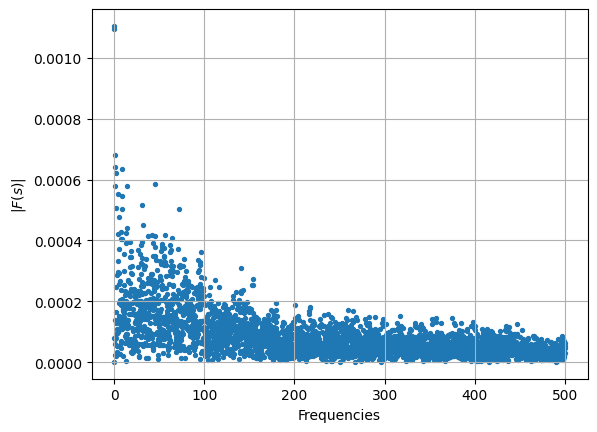

In [42]:
anim_length = V_tensor.shape[0]
for frame in range(anim_length):
    for dim in range(3):
        V_signal = V_tensor[frame, :, dim]
        V_smooth_signal = V_smooth_tensor[frame, :, dim]
        V_diff_signal = V_signal - V_smooth_signal
        
        V_fourier = torch.fft.rfft(V_signal, norm='forward')
        V_smooth_fourier = torch.fft.rfft(V_smooth_signal, norm='forward')
        V_diff_fourier = torch.fft.rfft(V_diff_signal, norm='forward')
        
        absolutes, freqs = plot_fft(V_diff_signal, V_diff_fourier)
        
        break
    
    break

In [ ]:
signal = V_diff_signal
sampling_rate = 1000

reconst_signal = torch.zeros(len(signal) * sampling_rate)
T = len(signal)
N = len(freqs)

for i in range(int(N-100), N):
    if i > len(freq) or i > len(absolutes):
        break
    f = freq[i]
    a = absolutes[i]
    t, y = generate_sine_wave(amplitude=a, frequency=f, phase=0, sampling_rate=sampling_rate, duration=T)
    reconst_signal += y

In [53]:
period = V.shape[1]
sampled_idx = (torch.linspace(0.25, 0.75, period) * sampling_rate).long()

print(reconst_signal[sampled_idx].shape)
V_diff_reconst = reconst_signal[sampled_idx]

torch.Size([6890])


In [ ]:
# PLOT THE ADDED JIGGLING ANIMATION

v_start = v_smooth_arr[0]
p = mp.plot(v_start, F)

for k in range(2):
    for i in range(anim_length):

        v_new = v_smooth_arr[i] 
        p.update_object(vertices=v_new)
        v = v_new
        time.sleep(0.1)